Imports and constants assignation

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf


### Constants
samples_per_record = 3327
fs = 16000
inputs = []
outputs = []
flag = True


# List of commands that the nn will recognize
# commands = ['now', 'take','fetch','noise','cancel','driver','pillow','slider','stick','stop','wrench','piston','crank']

commands = ['noise','go', 'take','bring','cancel','one','two','three','four','five','six','seven']
# commands = ['five','six','seven','noise']
num_commands = len(commands)

# create a one-hot encoded matrix that is used in the output
encoded_commands = np.eye(num_commands)

# Definir los parámetros para el espectrograma
win = np.hamming(1024)
nfft = 1024
hop = nfft // 2


Data parse

In [55]:

# read each csv file and push an input and output
for command_idx in range(num_commands):
  command = commands[command_idx]
  print(f"Processing index {command_idx} for command '{command}'.")
  
  output = encoded_commands[command_idx]
  
  df = np.loadtxt("data_set/" + command + ".txt")
  
  # calculate the number of command recordings in the file
  num_recordings = int(df.shape[0] / samples_per_record)
  
  print(f"\tThere are {num_recordings} recordings of the {command} command.")
  
  for i in range(num_recordings):
    tensor = []
    start = i*samples_per_record
    end = start+samples_per_record
    spec, freqs, times, _ = plt.specgram(df[start:end], NFFT=nfft, Fs=fs, window=win, noverlap=hop, mode='magnitude')
    plt.close()
    tensor = spec

    inputs.append(tensor)
    outputs.append(output)
  # print('\tSorting ',command)
  
  # convert the list to numpy array
  inputs = np.array(inputs)
  outputs = np.array(outputs)

  if flag:
      inputs_train = np.empty((0,inputs.shape[1],inputs.shape[2]))
      inputs_test = np.empty((0,513,5))
      inputs_validate = np.empty((0,513,5))
      outputs_train = np.empty((0,outputs.shape[1]))
      outputs_test = np.empty((0,outputs.shape[1]))
      outputs_validate = np.empty((0,outputs.shape[1]))
      temp_inputs_train = np.empty((0,513,5))
      temp_inputs_test = np.empty((0,513,5))
      temp_inputs_validate = np.empty((0,513,5))
      temp_outputs_train = np.empty((0,outputs.shape[1]))
      temp_outputs_test = np.empty((0,outputs.shape[1]))
      temp_outputs_validate = np.empty((0,outputs.shape[1]))
      flag = False

  # Sort inputs randomly
  num_inputs = len(inputs)
  random_idx = np.arange(num_inputs)
  np.random.shuffle(random_idx)

  inputs = inputs[random_idx]
  outputs = outputs[random_idx]

  # Split the inputs into: training (60%), testing(20%) and validation(20%)
  train_idx = int(0.8 * num_inputs)
  test_idx = int(0.1 * num_inputs + train_idx)

  temp_inputs_train, temp_inputs_test, temp_inputs_validate = np.split(inputs, [train_idx, test_idx])
  temp_outputs_train, temp_outputs_test, temp_outputs_validate = np.split(outputs, [train_idx, test_idx])
  
  
  inputs_train = np.vstack([inputs_train, temp_inputs_train])
  inputs_test = np.vstack([inputs_test, temp_inputs_test])
  inputs_validate = np.vstack([inputs_validate, temp_inputs_validate])
  # print('Inputs train shape: ',inputs_train.shape)

  outputs_train = np.vstack([outputs_train, temp_outputs_train])
  outputs_test = np.vstack([outputs_test, temp_outputs_test])
  outputs_validate = np.vstack([outputs_validate, temp_outputs_validate])

  inputs = []
  outputs = [] 

print("Data set parsing and preparation complete.")

Processing index 0 for command 'noise'.
	There are 105 recordings of the noise command.
Processing index 1 for command 'go'.
	There are 355 recordings of the go command.
Processing index 2 for command 'take'.
	There are 430 recordings of the take command.
Processing index 3 for command 'bring'.
	There are 303 recordings of the bring command.
Processing index 4 for command 'cancel'.
	There are 311 recordings of the cancel command.
Processing index 5 for command 'one'.
	There are 305 recordings of the one command.
Processing index 6 for command 'two'.
	There are 299 recordings of the two command.
Processing index 7 for command 'three'.
	There are 300 recordings of the three command.
Processing index 8 for command 'four'.
	There are 309 recordings of the four command.
Processing index 9 for command 'five'.
	There are 373 recordings of the five command.
Processing index 10 for command 'six'.
	There are 330 recordings of the six command.
Processing index 11 for command 'seven'.
	There are 3

Randomize samples

In [56]:

num_inputs = len(inputs_train)
random_idx = np.arange(num_inputs)
np.random.shuffle(random_idx)

inputs_train = inputs_train[random_idx]
outputs_train = outputs_train[random_idx]

# Ajustar la forma de los datos de entrada
inputs_train = np.expand_dims(inputs_train, axis=1)
inputs_validate = np.expand_dims(inputs_validate, axis=1)
inputs_test = np.expand_dims(inputs_test, axis=1)

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


Model training and bulding

In [57]:
# # build the model and train it

# # Define the input shape
# input_shape = inputs_train[1].shape

# # Define the number of filters and filter sizes for the first layer
# filters_layer_1 = 32
# filter_size_layer_1 = (5,5)
# model = 0
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Conv2D(filters=filters_layer_1, padding='same', kernel_size=filter_size_layer_1,activation='relu', input_shape=input_shape))
# model.add(tf.keras.layers.Conv2D(filters=filters_layer_1*2, padding='same', kernel_size=filter_size_layer_1,activation='relu'))
# model.add(tf.keras.layers.Conv2D(filters=filters_layer_1*4, padding='same', kernel_size=filter_size_layer_1,activation='relu'))
# model.add(tf.keras.layers.Conv2D(filters=filters_layer_1*8, padding='same', kernel_size=filter_size_layer_1,activation='relu'))
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(32, activation='relu'))
# model.add(tf.keras.layers.Dense(num_commands, activation='softmax'))
# # model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
# # optimizer= adam loss= crossentropy metrics = accuracy
# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# history = model.fit(inputs_train, outputs_train, epochs=100, batch_size=10, validation_data=(inputs_validate, outputs_validate), callbacks=[early_stop])

# # history = model.fit(inputs_train, outputs_train, epochs=30, batch_size=10, validation_data=(inputs_validate, outputs_validate))

In [58]:
from tensorflow.keras import regularizers
# build the model and train it

# Define the input shape
input_shape = inputs_train[1].shape

# Define the number of filters and filter sizes for the first layer
filters_layer_1 = 16
filter_size_layer_1 = (5,5)
model = 0
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=filters_layer_1, padding='same', kernel_size=filter_size_layer_1,
                                 activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.01)))

model.add(tf.keras.layers.Conv2D(filters=filters_layer_1*2, padding='same', kernel_size=filter_size_layer_1,
                                 activation='relu', kernel_regularizer=regularizers.l2(0.01)))

model.add(tf.keras.layers.Conv2D(filters=filters_layer_1*4, padding='same', kernel_size=filter_size_layer_1,
                                 activation='relu', kernel_regularizer=regularizers.l2(0.01)))

model.add(tf.keras.layers.Conv2D(filters=filters_layer_1*8, padding='same', kernel_size=filter_size_layer_1,
                                 activation='relu', kernel_regularizer=regularizers.l2(0.01)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

model.add(tf.keras.layers.Dense(num_commands, activation='softmax'))

# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(inputs_train, outputs_train, epochs=100, batch_size=1, validation_data=(inputs_validate, outputs_validate))


Epoch 1/100
2989/2989 [==============================] - 24s 8ms/step - loss: 2.0262 - accuracy: 0.3158 - val_loss: 1.5775 - val_accuracy: 0.4514
Epoch 2/100
2989/2989 [==============================] - 23s 8ms/step - loss: 1.4002 - accuracy: 0.5135 - val_loss: 1.5090 - val_accuracy: 0.5013
Epoch 3/100
2989/2989 [==============================] - 25s 8ms/step - loss: 1.2491 - accuracy: 0.5677 - val_loss: 1.4023 - val_accuracy: 0.5564
Epoch 4/100
2989/2989 [==============================] - 23s 8ms/step - loss: 1.1354 - accuracy: 0.6129 - val_loss: 1.2333 - val_accuracy: 0.5932
Epoch 5/100
2989/2989 [==============================] - 23s 8ms/step - loss: 1.0889 - accuracy: 0.6316 - val_loss: 1.3103 - val_accuracy: 0.5643
Epoch 6/100
2989/2989 [==============================] - 23s 8ms/step - loss: 1.0672 - accuracy: 0.6467 - val_loss: 1.1990 - val_accuracy: 0.6194
Epoch 7/100
2989/2989 [==============================] - 23s 8ms/step - loss: 1.0529 - accuracy: 0.6514 - val_loss: 1.1653 -

Loss graph

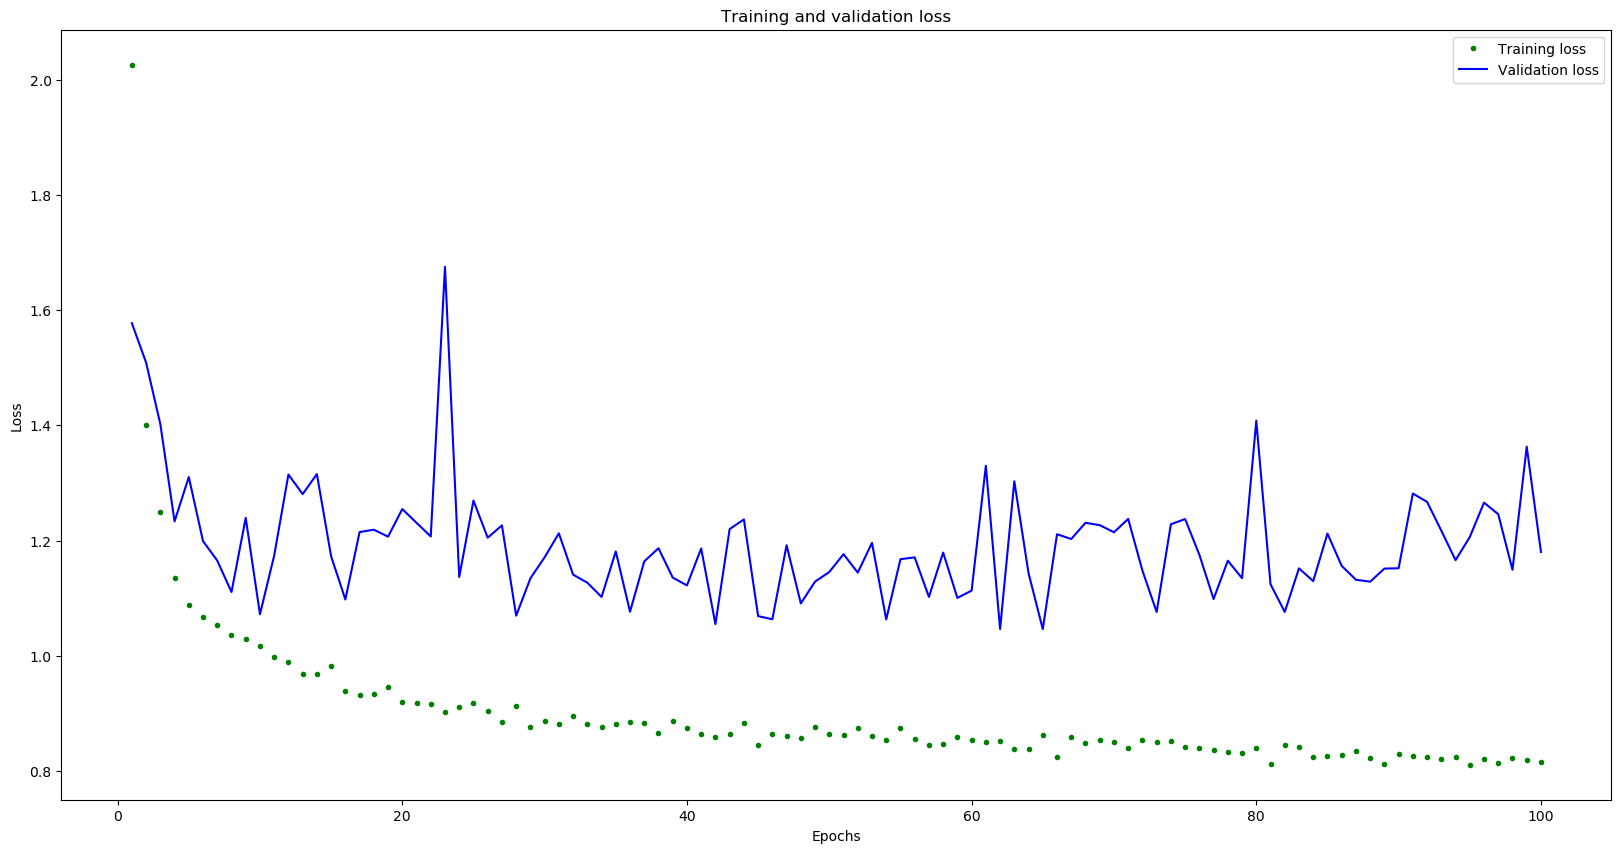

In [59]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


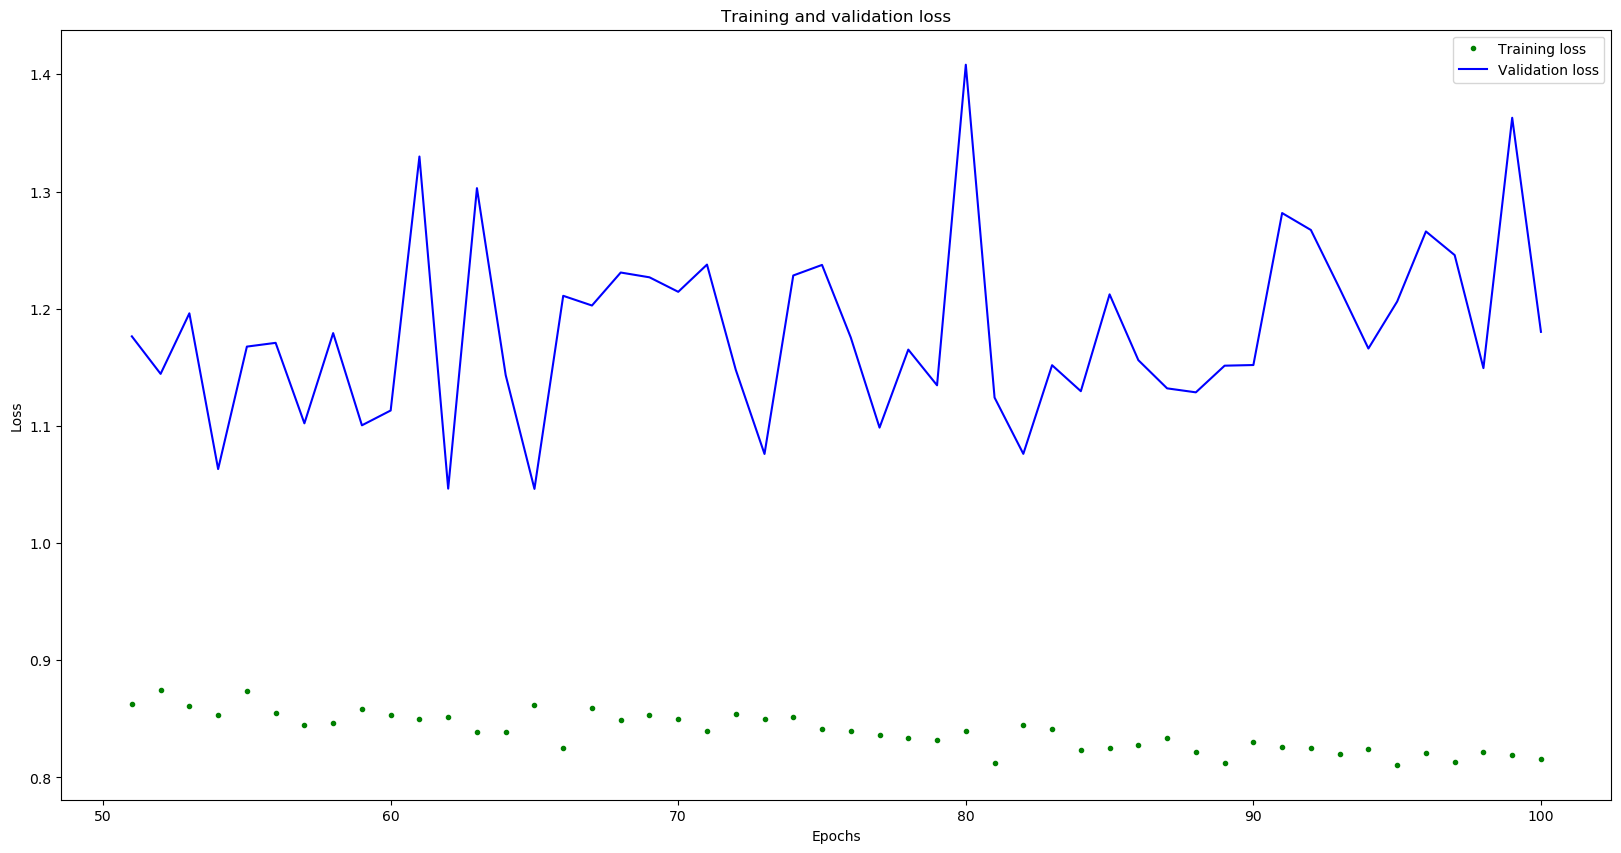

In [60]:
# graph the loss again skipping a bit of the start
SKIP = int(len(epochs)/2)
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Accuracy graph

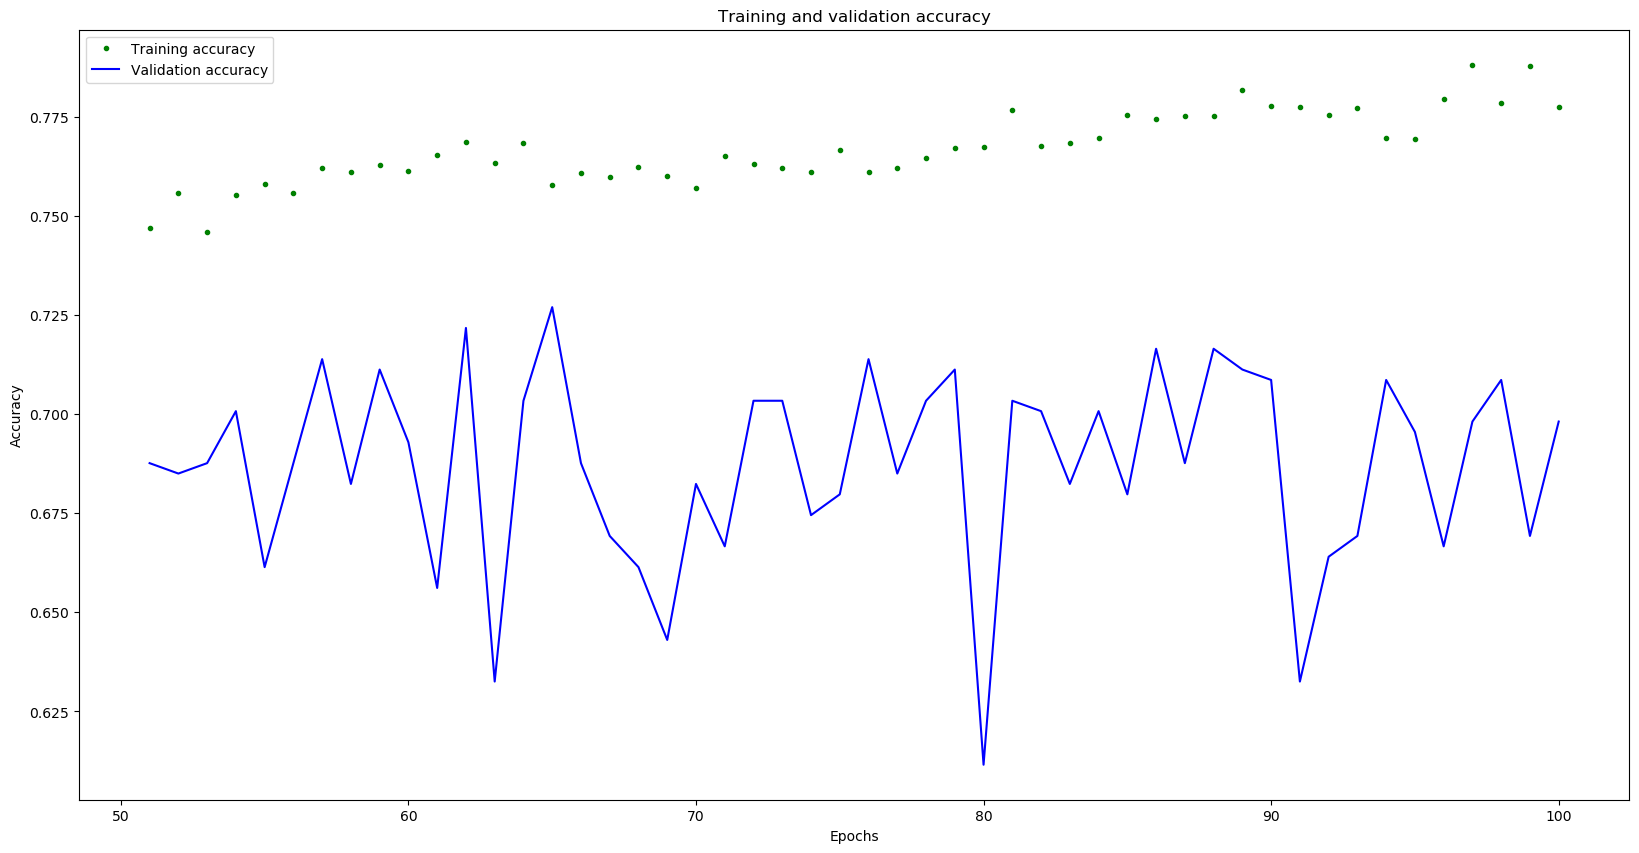

In [61]:
# graph of accuracy
mae = history.history['accuracy']
val_mae = history.history['val_accuracy']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training accuracy')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Test model predictions

12/12 [==============================] - 0s 7ms/step
class: 12


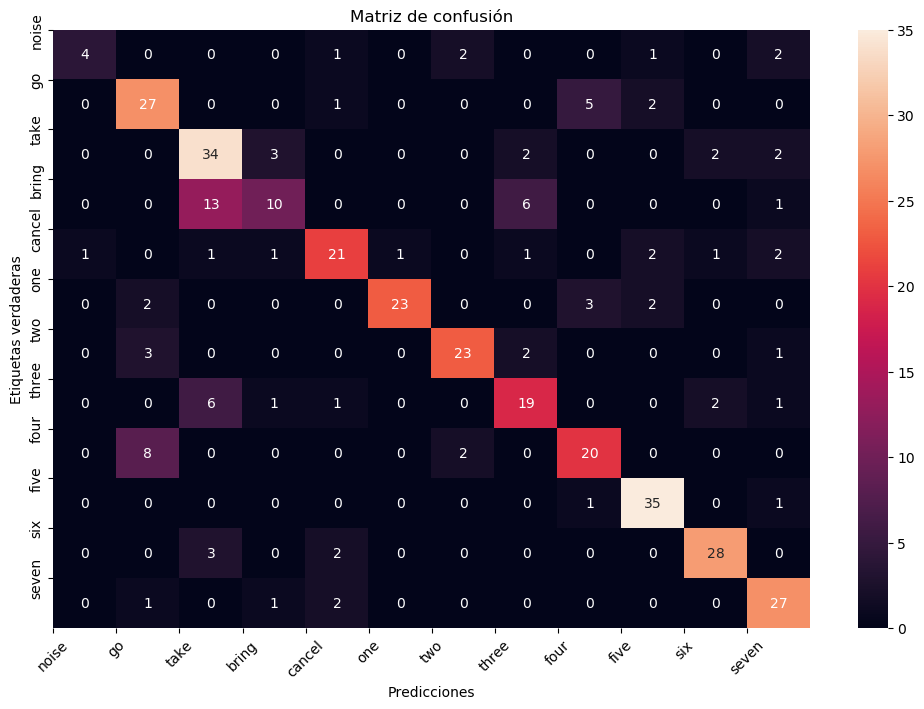

Accuracy: 0.7344173441734417


In [62]:
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
# use the model to predict the test inputs
# inputs_test = np.expand_dims(inputs_test, axis=1)
predictions = model.predict(inputs_test)

# Calcula la matriz de confusión utilizando NumPy
num_classes = len((outputs_test[1]))
print('class:',num_classes)
confusion_matrix = np.zeros((num_classes, num_classes))

for i in range(len(outputs_test)):
    true_class = np.argmax(outputs_test[i])
    predicted_class = np.argmax(predictions[i])
    confusion_matrix[true_class][predicted_class] += 1
# print(confusion_matrix)

# Imprime la matriz de confusión utilizando la biblioteca matplotlib.pyplot
# plt.imshow(confusion_matrix, cmap=plt.cm.Blues, annot=True)
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix, annot=True)
plt.title("Matriz de confusión")
# plt.colorbar()
tick_marks = np.arange(len(commands))
plt.xticks(tick_marks, commands, rotation=45)
plt.yticks(tick_marks, commands)
plt.tight_layout()
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas verdaderas')
plt.show()

## Accuracy

total_correct = 0
for i in range(num_classes):
    total_correct += confusion_matrix[i][i]

total = np.sum(confusion_matrix)
accuracy = total_correct / total

print('Accuracy:', accuracy)


Convert model to tensorflow lite

In [63]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("command_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("command_model.tflite")
print("Model is %d bytes" % basic_model_size)

INFO:tensorflow:Assets written to: /tmp/tmp_6k23ni4/assets


INFO:tensorflow:Assets written to: /tmp/tmp_6k23ni4/assets


Model is 9494948 bytes


2023-05-12 10:27:45.097125: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-05-12 10:27:45.097151: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-05-12 10:27:45.097314: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_6k23ni4
2023-05-12 10:27:45.098489: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-05-12 10:27:45.098502: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_6k23ni4
2023-05-12 10:27:45.102839: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-05-12 10:27:45.155102: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmp_6k23ni4
2023-05-12 10:27:45.164672: I tensorflow/cc/saved_model/loader.cc:314] SavedModel load for tags { serve }; Status: success: OK. Took 67358 m